# LongRunMIP
# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [17]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
from glob import glob
import matplotlib.pyplot as plt
import time
import json
import os
import sys
from numpy.typing import ArrayLike

warnings.filterwarnings('ignore')

In [18]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))

In [29]:
import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import xarray_class_accessors as xca
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import stats
import utils
logger = utils.get_notebook_logger()
import classes

In [9]:
notebook_number='00'

In [10]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:33329
-   dashboard at:         /proxy/8787/status
-         Start Nanny at: 'tcp://127.0.0.1:38295'
-         Start Nanny at: 'tcp://127.0.0.1:39839'
-         Start Nanny at: 'tcp://127.0.0.1:46315'
-         Start Nanny at: 'tcp://127.0.0.1:35209'
-         Start Nanny at: 'tcp://127.0.0.1:45953'
-         Start Nanny at: 'tcp://127.0.0.1:40977'
-         Start Nanny at: 'tcp://127.0.0.1:35253'
- Register worker <WorkerState 'tcp://127.0.0.1:34009', name: 2, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:34009
- Starting established connection to tcp://127.0.0.1:32930
- Register worker <WorkerState 'tcp://127.0.0.1:40343', name: 5, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:40343
- Starting established connection to tcp://127.0.0.1:32962
- Register worker <WorkerState 'tcp://127.0.0.1:40413', name: 6, status: init, memory: 0, processing: 0>
- 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33329,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:46157,Total threads: 1
Dashboard: /proxy/43417/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:38295,


# Loading Data

In [11]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]
experiment_params

{'variable': 'tas', 'mask': None, 'hemisphere': 'global'}

In [12]:
with open('/home/563/ab2313/Documents/PhD/data/longrunmip_model_lengths.json') as f:
    longrunmip_model_lengths = json.loads(f.read())

In [13]:
longrunmip_model_lengths

{'ccsm3': {'control': 1530, '4xCO2': 2120},
 'cesm104': {'control': 1000, '4xCO2': 5900},
 'cnrmcm61': {'control': 2000, '4xCO2': 1850},
 'ecearth': {'control': 508, '4xCO2': 150},
 'echam5mpiom': {'control': 100, '4xCO2': 1001},
 'famous': {'control': 3000, '4xCO2': 3000},
 'gfdlcm3': {'control': 5200, '4xCO2': 150},
 'gfdlcm3_2': {'control': 500, '4xCO2': 150},
 'gfdlesm2m': {'control': 1340, '4xCO2': 150},
 'gfdlesm2m_2': {'control': 500, '4xCO2': 150},
 'gisse2r': {'control': 128, '4xCO2': 5001},
 'hadcm3l': {'control': 1000, '4xCO2': 1000},
 'hadgem2': {'control': 239, '4xCO2': 1299},
 'ipslcm5a': {'control': 1000, '4xCO2': 1000},
 'miroc32': {'control': 681, '4xCO2': 150},
 'mpiesm11': {'control': 2000, '4xCO2': 4459},
 'mpiesm12': {'control': 1237, '4xCO2': 1000}}

In [32]:
ROOT_DIR_SPLINE = os.path.join(constants.LONGRUNMIP_DIR, experiment_params['variable'], 'log_cubic_spline', 'updated_time_stamp')

In [43]:
spline_files = glob(os.path.join(ROOT_DIR_SPLINE, '*.nc'))
spline_files = [os.path.basename(f) for f in spline_files]

In [50]:
trend_ds = open_ds.read_and_merge_netcdfs(spline_files, ROOT_DIR_SPLINE, logginglevel='ERROR')
trend_ds = trend_ds.to_array(dim='model')
trend_ds

- model='ecearth' is too short has time_length=150 < requested_length=800
(fname='tas_mon_ECEARTH_abrupt4x_150_g025.nc')
- model='miroc32' is too short has time_length=150 < requested_length=800
(fname='tas_mon_MIROC32_abrupt4x_150_g025.nc')
- model='gfdlcm3' is too short has time_length=150 < requested_length=800
(fname='tas_ann_GFDLCM3_abrupt4x_150_g025.nc')
- model='gfdlesm2m' is too short has time_length=150 < requested_length=800
(fname='tas_ann_GFDLESM2M_abrupt4x_150_g025.nc')


<xarray.DataArray (model: 11, time: 1000, lat: 72, lon: 144)>
array([[[[-4.33649902e+01, -4.36649475e+01, -4.36664581e+01, ...,
          -4.28144684e+01, -4.30791626e+01, -4.30805206e+01],
         [-4.16297913e+01, -4.19551849e+01, -4.23027954e+01, ...,
          -4.07306976e+01, -4.10019836e+01, -4.13120575e+01],
         [-3.70140686e+01, -3.76890869e+01, -3.84201660e+01, ...,
          -3.51471100e+01, -3.57075500e+01, -3.63535156e+01],
         ...,
         [-1.37371521e+01, -1.36635742e+01, -1.36394653e+01, ...,
          -1.40611572e+01, -1.39245605e+01, -1.38241882e+01],
         [-1.58782349e+01, -1.58097229e+01, -1.57673035e+01, ...,
          -1.60631714e+01, -1.59929199e+01, -1.59393311e+01],
         [-1.66355896e+01, -1.65641785e+01, -1.65637817e+01, ...,
          -1.67858582e+01, -1.67102356e+01, -1.67098999e+01]],

        [[-4.27852325e+01, -4.31231384e+01, -4.31248474e+01, ...,
          -4.21556244e+01, -4.24601288e+01, -4.24616852e+01],
         [-4.10272369e+01, -4.13982239e+01, -4.17825775e+01, ...,
          -4.00010376e+01, -4.03164215e+01, -4.06666565e+01],
         [-3.63613434e+01, -3.71455688e+01, -3.79480286e+01, ...,
          -3.42447968e+01, -3.48855133e+01, -3.56079865e+01],
...
          -2.48748779e+00, -2.43841553e+00, -2.41232300e+00],
         [-3.42001343e+00, -3.41320801e+00, -3.41915894e+00, ...,
          -3.44314575e+00, -3.44461060e+00, -3.43048096e+00],
         [-4.19451904e+00, -4.19635010e+00, -4.19345093e+00, ...,
          -4.18905640e+00, -4.18957520e+00, -4.19226074e+00]],

        [[-3.62254944e+01, -3.63221283e+01, -3.64195709e+01, ...,
          -3.59446564e+01, -3.60221558e+01, -3.61255035e+01],
         [-3.47904816e+01, -3.50323792e+01, -3.53122559e+01, ...,
          -3.39067688e+01, -3.41340637e+01, -3.44910431e+01],
         [-3.30588837e+01, -3.35888367e+01, -3.41799927e+01, ...,
          -3.13611603e+01, -3.19828949e+01, -3.25235748e+01],
         ...,
         [ 9.96920997e+36,  9.96920997e+36,  9.96920997e+36, ...,
           9.96920997e+36,  9.96920997e+36,  9.96920997e+36],
         [ 9.96920997e+36,  9.96920997e+36,  9.96920997e+36, ...,
           9.96920997e+36,  9.96920997e+36,  9.96920997e+36],
         [ 9.96920997e+36,  9.96920997e+36,  9.96920997e+36, ...,
           9.96920997e+36,  9.96920997e+36,  9.96920997e+36]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * model    (model) object 'echam5mpiom' 'ukesm' ... 'hadcm3l' 'ipslcm5a'
Attributes:
    length:   1001

In [52]:
trend_ds = trend_ds.where(trend_ds.model.isin(experiment_da.model.values), drop=True)

In [14]:
control_da = open_ds.open_experiment_files(experiment_params, ExperimentTypes.CONTROL)
experiment_da = open_ds.open_experiment_files(experiment_params, ExperimentTypes.ABRUPT4X)



- Opening control
- ['ccsm3' 'cesm104' 'cnrmcm61' 'hadcm3l' 'ipslcm5a' 'mpiesm11' 'mpiesm12']=
- /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped=
- Opening files in /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CCSM3_control_1530_g025.nc
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CESM104_control_1000_g025.nc
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CNRMCM61_control_2000_g025.nc
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_HadCM3L_control_1000_g025.nc
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/t

In [16]:
experiment_da

<xarray.DataArray 'tas' (model: 7, time: 1000, lat: 72, lon: 144)>
array([[[[-36.43565369, -36.81057739, -36.81245422, ..., -35.71696472,
          -36.06871033, -36.07048035],
         [-35.83706665, -36.22055054, -36.60476685, ..., -34.76939392,
          -35.10934448, -35.46665955],
         [-34.38406372, -35.11457825, -35.85514832, ..., -32.33750916,
          -32.98893738, -33.67550659],
         ...,
         [-12.75921631, -12.60821533, -12.4822998 , ..., -13.46795654,
          -13.2043457 , -12.95788574],
         [-13.29620361, -13.22479248, -13.16625977, ..., -13.57479858,
          -13.47198486, -13.37860107],
         [-13.48236084, -13.43884277, -13.43865967, ..., -13.60546875,
          -13.54193115, -13.54165649]],

        [[-35.26338196, -35.61485291, -35.61660767, ..., -34.58970642,
          -34.91957092, -34.92121887],
         [-34.62380981, -34.97756958, -35.33317566, ..., -33.62643433,
          -33.94223022, -34.27870178],
         [-33.04078674, -33.71427917, -34.39067078, ..., -31.14250183,
          -31.74208069, -32.38339233],
...
         [  2.75164795,   2.96948242,   3.15542603, ...,   1.92614746,
            2.22518921,   2.50192261],
         [  1.74664307,   1.76834106,   1.79043579, ...,   1.66842651,
            1.69842529,   1.72290039],
         [  0.8885498 ,   0.88684082,   0.88406372, ...,   0.89547729,
            0.89190674,   0.89016724]],

        [[-38.21391296, -38.19351196, -38.13035583, ..., -38.23843384,
          -38.2270813 , -38.22709656],
         [-35.58676147, -35.70545959, -35.82852173, ..., -34.9808197 ,
          -35.21842957, -35.43595886],
         [-33.69770813, -33.92037964, -34.07203674, ..., -32.58488464,
          -33.02529907, -33.39717102],
         ...,
         [  2.35177612,   2.6071167 ,   2.85293579, ...,   1.43942261,
            1.77731323,   2.08026123],
         [  1.43826294,   1.47998047,   1.51397705, ...,   1.28128052,
            1.33755493,   1.38891602],
         [  0.9871521 ,   0.98684692,   0.98693848, ...,   0.99081421,
            0.98876953,   0.98791504]]]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height   float64 ...
  * model    (model) object 'ccsm3' 'cesm104' ... 'mpiesm11' 'mpiesm12'
Attributes:
    length:   2120

# Calculation

## Trend Fitting

In [11]:
experiment_da_smean = experiment_da.mean(dim=['lat', 'lon']).compute()

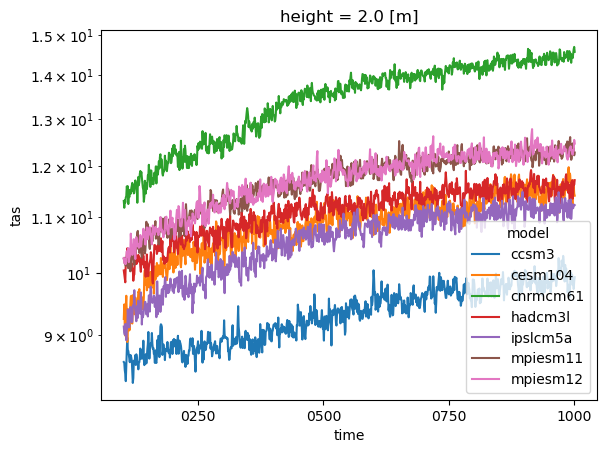

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
experiment_da_smean.isel(time=slice(100, None)).plot(ax=ax, hue='model')

ax.set_yscale('log')
# ax.set_xscale('log')

In [ ]:
p

In [8]:
trend_da1 = stats.trend_fit(experiment_da.isel(time=slice(0,100)), method='polynomial', order=6)
trend_da2 = stats.trend_fit(experiment_da.isel(time=slice(100,None)), method='polynomial', order=6)

In [9]:
trend_da = trend_da1.combine_first(trend_da2).chunk({'time':-1}).persist()
detrended_da = (experiment_da - trend_da).persist()
trend_da

<xarray.DataArray 'tas' (model: 7, lat: 72, lon: 144, time: 1000)>
dask.array<xarray-<this-array>, shape=(7, 72, 144, 1000), dtype=float64, chunksize=(7, 72, 144, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * model    (model) object 'ccsm3' 'cesm104' ... 'mpiesm11' 'mpiesm12'
    height   float64 2.0

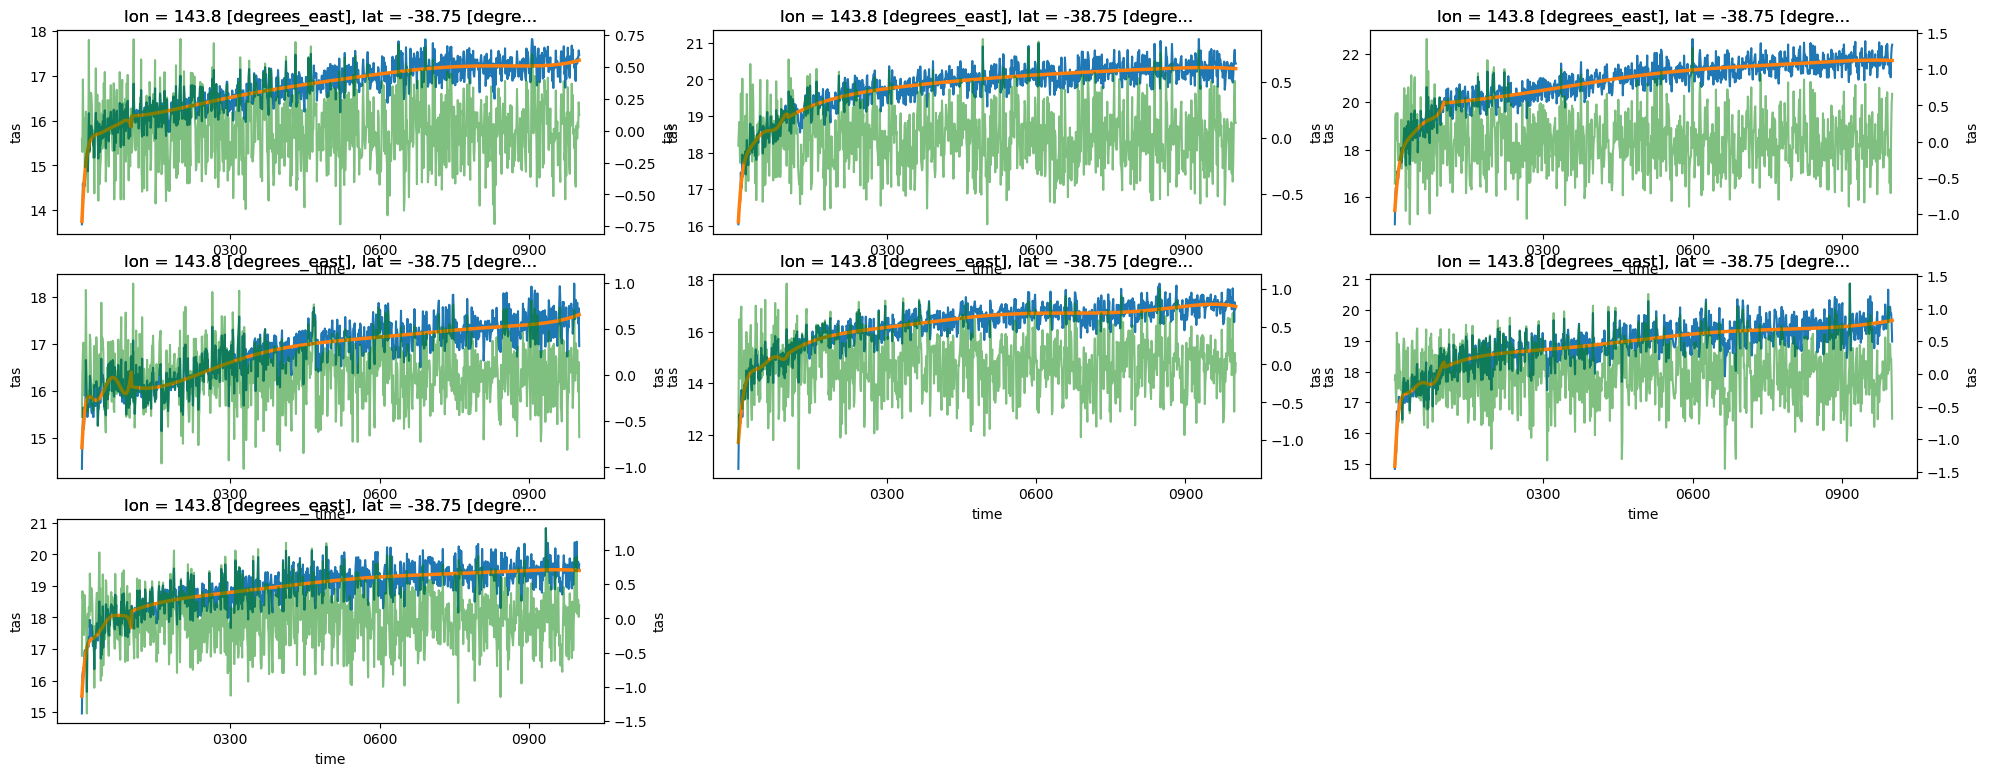

In [10]:
sel_kwargs = dict(lat=-38, lon=144, method='nearest')

models = detrended_da.model.values
ncols = 3
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(8*ncols, 3*nrows))
for plot_num, model in enumerate(models):
    ax = fig.add_subplot(nrows,ncols,plot_num+1)
    experiment_da.sel(**sel_kwargs).sel(model=model).plot(ax=ax)
    trend_da.sel(**sel_kwargs).sel(model=model).plot(ax=ax, linewidth=2.5)
    ax2 = ax.twinx()
    detrended_da.sel(**sel_kwargs).sel(model=model).plot(ax=ax2, zorder=-100, alpha=0.5, color='green')

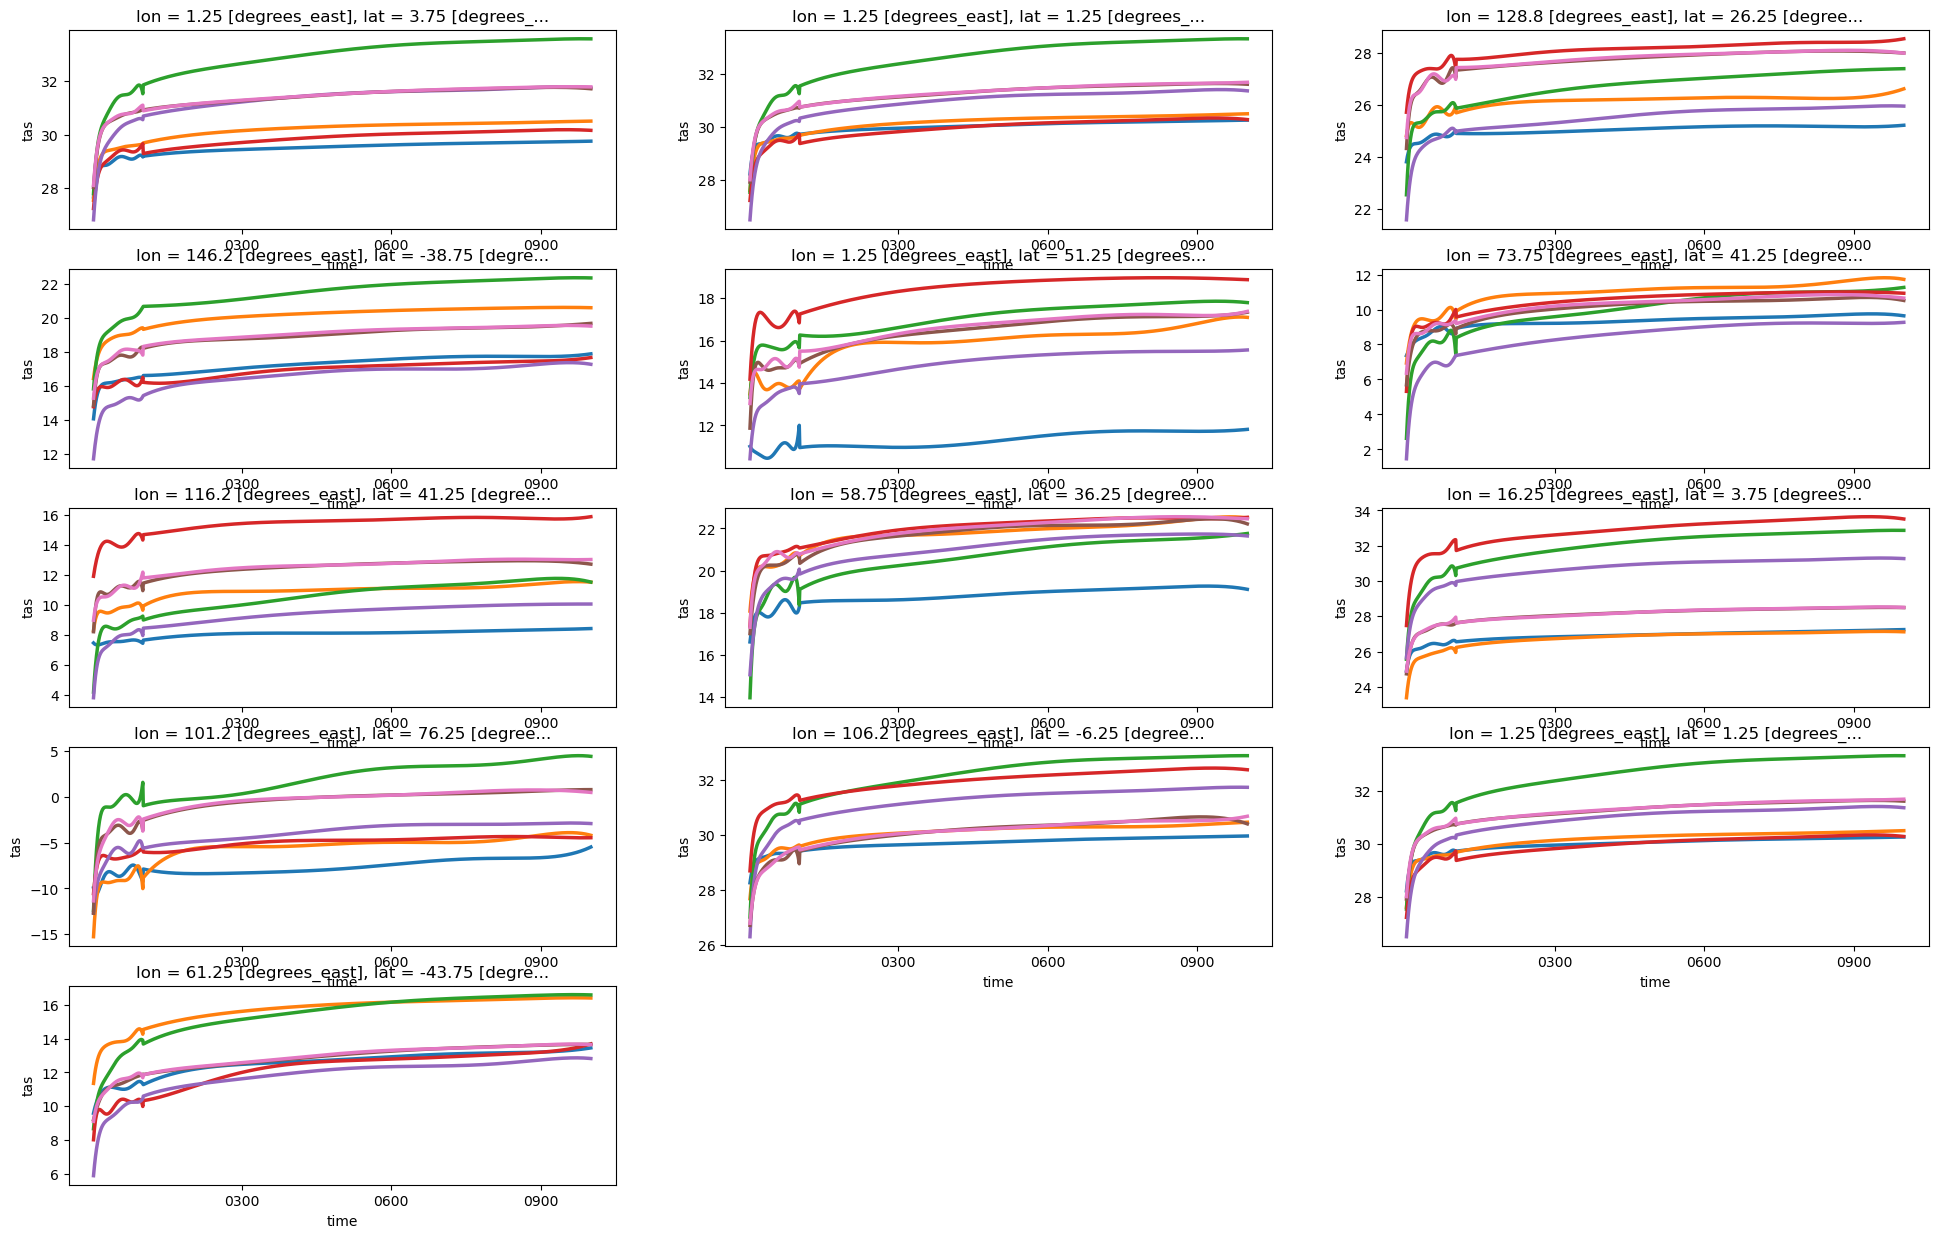

In [11]:
locations = list(classes.LocationsLatLon)
models = detrended_da.model.values
ncols = 3
nrows = int(np.ceil(len(locations)/ncols))
fig = plt.figure(figsize=(8*ncols, 3*nrows))

for plot_num,loc in enumerate(locations):
    latlon = loc.value
    ax = fig.add_subplot(nrows,ncols,plot_num+1)
    for model in models:
        trend_da.sel(lat=latlon[0], lon=latlon[1], method='nearest').sel(model=model).plot(ax=ax, linewidth=2.5)

## Calculations

In [12]:
data_dict = {'control':control_da, 'exp':experiment_da}

In [13]:
SAVE_DIR = os.path.join(constants.LONGRUNMIP_DIR, experiment_params['variable'], 'signal_to_noise')

In [14]:
os.listdir(SAVE_DIR)

['mpiesm12_control_rolling_noise_True_time_slice_None.nc',
 'cnrmcm61_control_rolling_noise_False_time_slice_(0, 100).nc',
 'cesm104_control_rolling_noise_True_time_slice_(0, 100).nc',
 'mpiesm11_control_rolling_noise_False_time_slice_None.nc',
 'hadcm3l_control_rolling_noise_False_time_slice_(0, 100).nc',
 'cesm104_control_rolling_noise_True_time_slice_None.nc',
 'ccsm3_exp_rolling_noise_True_time_slice_None.nc',
 'mpiesm11_control_rolling_noise_False_time_slice_(0, 100).nc',
 'mpiesm12_control_rolling_noise_False_time_slice_None.nc',
 'ccsm3_control_rolling_noise_True_time_slice_None.nc',
 'hadcm3l_control_rolling_noise_True_time_slice_None.nc',
 'ccsm3_control_rolling_noise_True_time_slice_(0, 100).nc',
 'ipslcm5a_control_rolling_noise_True_time_slice_(0, 100).nc',
 'old',
 'ipslcm5a_control_rolling_noise_False_time_slice_None.nc',
 'cnrmcm61_control_rolling_noise_True_time_slice_(0, 100).nc',
 'mpiesm11_control_rolling_noise_True_time_slice_(0, 100).nc',
 'ipslcm5a_control_rolling_

In [15]:
rolling_noise_types = [True, False]

In [16]:
time_slices = [(0, 100), None]

In [17]:
# experiment_da = experiment_da.copy()

In [18]:
models = experiment_da.model.values
models

array(['ccsm3', 'cesm104', 'cnrmcm61', 'hadcm3l', 'ipslcm5a', 'mpiesm11',
       'mpiesm12'], dtype=object)

In [19]:
for dtype, full_ds in data_dict.items():
    for rolling_noise in rolling_noise_types:
        for time_slice in time_slices:
            for model in models:
                t1 = time.perf_counter()
                save_name =  f'{model}_{dtype}_rolling_noise_{rolling_noise}_time_slice_{time_slice}.nc'
                print(f' - File to save is {save_name}')
    
                ds = full_ds.sel(model=model)
        
                # Check if file has already been saved or
                # Rolling nosie is True and we are slicing time (not compatable)
                has_not_been_saved = not (save_name in os.listdir(SAVE_DIR))
                is_compatable = not (rolling_noise and time_slice)
                to_run:bool = has_not_been_saved and is_compatable
                print(f' - *** {has_not_been_saved=}, {is_compatable=}, {to_run=}')
                if to_run:
                    print(' -  Running')
                    da_for_noise = detrended_da.sel(model=model) if dtype == 'exp' else ds
                    sn_ds = sn.multiwindow_signal_to_noise(
                        ds, rolling_noise=rolling_noise, da_for_noise=da_for_noise,
                        time_slice=time_slice, return_all=True, windows=constants.LONGRUNMIP_WINDOWS)
                    sn_ds = sn_ds.persist()
                    sn_ds.to_netcdf(os.path.join(SAVE_DIR, save_name))  
                else:
                    print(' - Already run or not compatable')
                    
                total_time = time.perf_counter() - t1
                print(f'{total_time=}')
            print('\n-----------\n')

 - File to save is ccsm3_control_rolling_noise_True_time_slice_(0, 100).nc
 - *** has_not_been_saved=False, is_compatable=False, to_run=False
 - Already run or not compatable
total_time=0.004856099374592304
 - File to save is cesm104_control_rolling_noise_True_time_slice_(0, 100).nc
 - *** has_not_been_saved=False, is_compatable=False, to_run=False
 - Already run or not compatable
total_time=0.002113308757543564
 - File to save is cnrmcm61_control_rolling_noise_True_time_slice_(0, 100).nc
 - *** has_not_been_saved=False, is_compatable=False, to_run=False
 - Already run or not compatable
total_time=0.0039624059572815895
 - File to save is hadcm3l_control_rolling_noise_True_time_slice_(0, 100).nc
 - *** has_not_been_saved=False, is_compatable=False, to_run=False
 - Already run or not compatable
total_time=0.0040648868307471275
 - File to save is ipslcm5a_control_rolling_noise_True_time_slice_(0, 100).nc
 - *** has_not_been_saved=False, is_compatable=False, to_run=False
 - Already run or 